In [1]:
import torch
import json
import numpy as np
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sparse_auto_encoder import SparseAutoencoder
from utils.model import load_GPT_model
from saes__extract_latent_activations import exract_latent_activations
from saes__filter_selective_neurons import find_selective_neurons
from saes__neuron_concept_assoc import calculate_neuron_to_concept_assoc
from saes__top_texts_for_neuron import top_texts_for_neuron
from saes__neuron_concept_mapping import build_neuron_concept_map

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

color_map = {
    "female": "#FAD7AC",
    "male": "#cc9290",
    "marriage": "#ed76b3",
    "love": "#f4847a",
    "wealth": "#DAE8FC",
    "emotion": "#9467bd",
    "family": "#D0CEE1",
    "duty": "#a4d9f2",
    "scandal and reputation": "#BAC8D3",
    "society": "#D5E7D4",
    "neutral": "#e5ced0",
    "class": "#90ee90"
}

def plot_dual_theme_graph_from_csv(
    csv_path, *, color_map=color_map, ax=None, return_fig=False, seed=62,
    layout="spring",    # "spring" or "kk"
    spread=1.8          # >1 spreads nodes further apart
):
    """Reads primary/secondary CSV and plots the dual-theme concept graph (same styling)."""
    df = pd.read_csv(csv_path)
    if "primary_concept" not in df.columns or "secondary_concept" not in df.columns:
        raise ValueError("CSV must contain 'primary_concept' and 'secondary_concept' columns.")
    df = df.dropna(subset=["primary_concept", "secondary_concept"])

    # Build edges (orderless pairs)
    edges = []
    for _, row in df.iterrows():
        a = str(row["primary_concept"]).strip(" ,").lower()
        b = str(row["secondary_concept"]).strip(" ,").lower()
        if a and b and a != "unk" and b != "unk":
            edges.append((a, b))

    if not edges:
        fig, axp = plt.subplots(figsize=(6, 3))
        axp.text(0.5, 0.5, "No dual-theme data", ha="center", va="center")
        axp.axis("off")
        fig.tight_layout()
        return (fig, axp) if return_fig else None

    G = nx.MultiGraph()
    G.add_edges_from(edges)

    # Create axes if needed
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(13, 9))
        created_fig = True
    else:
        fig = ax.figure

    # ---- Layout: more spread ----
    if layout == "kk":
        pos = nx.kamada_kawai_layout(G)  # tends to spread nicely
    else:
        # Increase k (ideal distance) & iterations to push nodes apart
        base_k = 0.75 / max(len(G.nodes), 1) ** 0.25
        k = base_k * spread
        pos = nx.spring_layout(G, k=k, seed=seed, iterations=200)

    # (Optional) small radial widening to reduce overlap while preserving shape
    if spread > 1.0:
        xs, ys = zip(*pos.values())
        cx, cy = sum(xs)/len(xs), sum(ys)/len(ys)
        for n in pos:
            x, y = pos[n]
            pos[n] = (cx + (x - cx) * 1.15, cy + (y - cy) * 1.15)

    unique_nodes = list(G.nodes())
    node_colors = [color_map.get(node, "#cccccc") for node in unique_nodes]

    # ---- Draw (unchanged styling) ----
    nx.draw_networkx_nodes(G, pos, node_size=8000, node_color=node_colors, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", ax=ax)

    drawn = set()
    for u, v in G.edges():
        key = tuple(sorted((u, v)))
        if key in drawn:
            continue
        width = 1 + G.number_of_edges(u, v)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=0.5, ax=ax)
        drawn.add(key)

    ax.set_title("Dual-Theme SAE Neuron Concept Graph", fontsize=16)
    ax.axis("off")
    fig.tight_layout()

    if return_fig:
        return fig, ax

In [3]:
device = "cpu"

In [4]:
model = load_GPT_model(path="model_896_14_8_256.pth", device=device)

In [5]:
sae_1 = SparseAutoencoder(input_dim=896, hidden_dim=2688).to(device)
sae_1.load_state_dict(torch.load("sae_models/sae_layer1.pth", map_location=torch.device('cpu')))
sae_1.eval();

sae_2 = SparseAutoencoder(input_dim=896, hidden_dim=2688).to(device)
sae_2.load_state_dict(torch.load("sae_models/sae_layer2.pth", map_location=torch.device('cpu')))
sae_2.eval();

sae_3 = SparseAutoencoder(input_dim=896, hidden_dim=3584).to(device)
sae_3.load_state_dict(torch.load("sae_models/sae_layer3.pth", map_location=torch.device('cpu')))
sae_3.eval();

sae_4 = SparseAutoencoder(input_dim=896, hidden_dim=3584).to(device)
sae_4.load_state_dict(torch.load("sae_models/sae_layer4.pth", map_location=torch.device('cpu')))
sae_4.eval();

sae_5 = SparseAutoencoder(input_dim=896, hidden_dim=3584).to(device)
sae_5.load_state_dict(torch.load("sae_models/sae_layer5.pth", map_location=torch.device('cpu')))
sae_5.eval();

sae_6 = SparseAutoencoder(input_dim=896, hidden_dim=4480).to(device)
sae_6.load_state_dict(torch.load("sae_models/sae_layer6.pth", map_location=torch.device('cpu')))
sae_6.eval();

sae_7 = SparseAutoencoder(input_dim=896, hidden_dim=4480).to(device)
sae_7.load_state_dict(torch.load("sae_models/sae_layer7.pth", map_location=torch.device('cpu')))
sae_7.eval();

sae_8 = SparseAutoencoder(input_dim=896, hidden_dim=4480).to(device)
sae_8.load_state_dict(torch.load("sae_models/sae_layer8.pth", map_location=torch.device('cpu')))
sae_8.eval();

In [6]:
latents_l1 = exract_latent_activations(model, sae_1, layer=1, dataset_path="themes_analysis_v2.csv")
latents_l2 = exract_latent_activations(model, sae_2, layer=2, dataset_path="themes_analysis_v2.csv")
latents_l3 = exract_latent_activations(model, sae_3, layer=3, dataset_path="themes_analysis_v2.csv")
latents_l4 = exract_latent_activations(model, sae_4, layer=4, dataset_path="themes_analysis_v2.csv")
latents_l5 = exract_latent_activations(model, sae_5, layer=5, dataset_path="themes_analysis_v2.csv")
latents_l6 = exract_latent_activations(model, sae_6, layer=6, dataset_path="themes_analysis_v2.csv")
latents_l7 = exract_latent_activations(model, sae_7, layer=7, dataset_path="themes_analysis_v2.csv")
latents_l8 = exract_latent_activations(model, sae_8, layer=8, dataset_path="themes_analysis_v2.csv")

✅ Saved sae_probing/latent_activations_l1.pt with latents shape torch.Size([607, 2688]) and 607 ids.
✅ Saved sae_probing/latent_activations_l2.pt with latents shape torch.Size([607, 2688]) and 607 ids.
✅ Saved sae_probing/latent_activations_l3.pt with latents shape torch.Size([607, 3584]) and 607 ids.
✅ Saved sae_probing/latent_activations_l4.pt with latents shape torch.Size([607, 3584]) and 607 ids.
✅ Saved sae_probing/latent_activations_l5.pt with latents shape torch.Size([607, 3584]) and 607 ids.
✅ Saved sae_probing/latent_activations_l6.pt with latents shape torch.Size([607, 4480]) and 607 ids.
✅ Saved sae_probing/latent_activations_l7.pt with latents shape torch.Size([607, 4480]) and 607 ids.
✅ Saved sae_probing/latent_activations_l8.pt with latents shape torch.Size([607, 4480]) and 607 ids.


In [7]:
def map_layer_neurons(layer, activation_threshold=5.0):
    find_selective_neurons(layer=layer, activation_threshold=activation_threshold)
    calculate_neuron_to_concept_assoc(layer=layer, threshold=activation_threshold);

    mappings = build_neuron_concept_map(layer=layer)
    print(f"✅ Done for layer {layer}")
    print('='*10)
    
    return mappings.head()

In [8]:
try:
    map_layer_neurons(layer=1)
except:
    print("⛔ No dual themed neurons found")

Layer 1: N=607 tokensets, H=2688 neurons.
Window [5, 150], thresh=5.0. Selective found: 0
-> IDs saved to: sae_probing\selective_neuron_ids_l1.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l1.csv (0 rows)
⛔ No dual themed neurons found


In [9]:
map_layer_neurons(layer=2)

Layer 2: N=607 tokensets, H=2688 neurons.
Window [5, 150], thresh=5.0. Selective found: 5
-> IDs saved to: sae_probing\selective_neuron_ids_l2.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l2.csv (55 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l2.csv
✅ Done for layer 2


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,2,999,family,0.260365,female,0.235721,0.094654,two-strong
1,2,1240,marriage,0.250420,society,0.242329,0.032309,two-strong
2,2,1580,family,0.290439,female,0.246444,0.151478,two-strong
3,2,2255,emotion,0.270505,wealth,0.224555,0.169867,two-strong
4,2,2403,family,0.369134,male,0.323729,0.123005,two-strong


In [10]:
map_layer_neurons(layer=3)

Layer 3: N=607 tokensets, H=3584 neurons.
Window [5, 150], thresh=5.0. Selective found: 16
-> IDs saved to: sae_probing\selective_neuron_ids_l3.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l3.csv (176 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l3.csv
✅ Done for layer 3


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,3,181,female,0.254429,wealth,0.202861,0.202682,leaning
1,3,344,marriage,0.248354,society,0.243808,0.018306,two-strong
2,3,383,female,0.231604,society,0.228724,0.012435,two-strong
3,3,1137,female,0.215818,wealth,0.198235,0.081472,two-strong
4,3,1230,male,0.228221,emotion,0.210888,0.075951,two-strong


In [11]:
map_layer_neurons(layer=4)

Layer 4: N=607 tokensets, H=3584 neurons.
Window [5, 150], thresh=5.0. Selective found: 27
-> IDs saved to: sae_probing\selective_neuron_ids_l4.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l4.csv (297 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l4.csv
✅ Done for layer 4


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,4,10,society,0.238908,duty,0.134597,0.436616,leaning
1,4,60,marriage,0.276255,family,0.262168,0.050993,two-strong
2,4,208,female,0.253591,male,0.231406,0.087485,two-strong
3,4,437,male,0.263857,family,0.242820,0.079730,two-strong
4,4,484,female,0.251325,family,0.211483,0.158529,two-strong


In [12]:
map_layer_neurons(layer=5)

Layer 5: N=607 tokensets, H=3584 neurons.
Window [5, 150], thresh=5.0. Selective found: 47
-> IDs saved to: sae_probing\selective_neuron_ids_l5.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l5.csv (517 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l5.csv
✅ Done for layer 5


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,5,60,male,0.209103,wealth,0.169200,0.190827,two-strong
1,5,221,marriage,0.285369,wealth,0.222207,0.221335,leaning
2,5,287,female,0.217531,wealth,0.196476,0.096789,two-strong
3,5,383,society,0.334109,emotion,0.231929,0.305828,leaning
4,5,404,female,0.272775,male,0.227725,0.165154,two-strong


In [13]:
map_layer_neurons(layer=6)

Layer 6: N=607 tokensets, H=4480 neurons.
Window [5, 150], thresh=5.0. Selective found: 78
-> IDs saved to: sae_probing\selective_neuron_ids_l6.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l6.csv (858 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l6.csv
✅ Done for layer 6


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,6,2,society,0.285095,emotion,0.238833,0.162269,two-strong
1,6,70,marriage,0.263950,duty,0.166600,0.368823,leaning
2,6,101,family,0.218750,male,0.192326,0.120797,two-strong
3,6,271,female,0.252395,marriage,0.252116,0.001104,two-strong
4,6,376,society,0.252861,wealth,0.217251,0.140829,two-strong


In [14]:
map_layer_neurons(layer=7)

Layer 7: N=607 tokensets, H=4480 neurons.
Window [5, 150], thresh=5.0. Selective found: 114
-> IDs saved to: sae_probing\selective_neuron_ids_l7.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l7.csv (1254 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l7.csv
✅ Done for layer 7


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,7,19,female,0.242127,family,0.193480,0.200915,leaning
1,7,98,marriage,0.291435,society,0.268213,0.079684,two-strong
2,7,101,family,0.223808,female,0.206555,0.077086,two-strong
3,7,121,family,0.328629,society,0.257613,0.216097,leaning
4,7,199,society,0.255260,wealth,0.228234,0.105875,two-strong


In [15]:
map_layer_neurons(layer=8)

Layer 8: N=607 tokensets, H=4480 neurons.
Window [5, 150], thresh=5.0. Selective found: 137
-> IDs saved to: sae_probing\selective_neuron_ids_l8.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l8.csv (1507 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l8.csv
✅ Done for layer 8


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,8,5,marriage,0.253487,society,0.228562,0.098328,two-strong
1,8,23,marriage,0.255478,female,0.238520,0.066378,two-strong
2,8,39,family,0.262632,female,0.229333,0.126788,two-strong
3,8,128,male,0.234782,wealth,0.218961,0.067389,two-strong
4,8,146,marriage,0.249171,society,0.240758,0.033763,two-strong


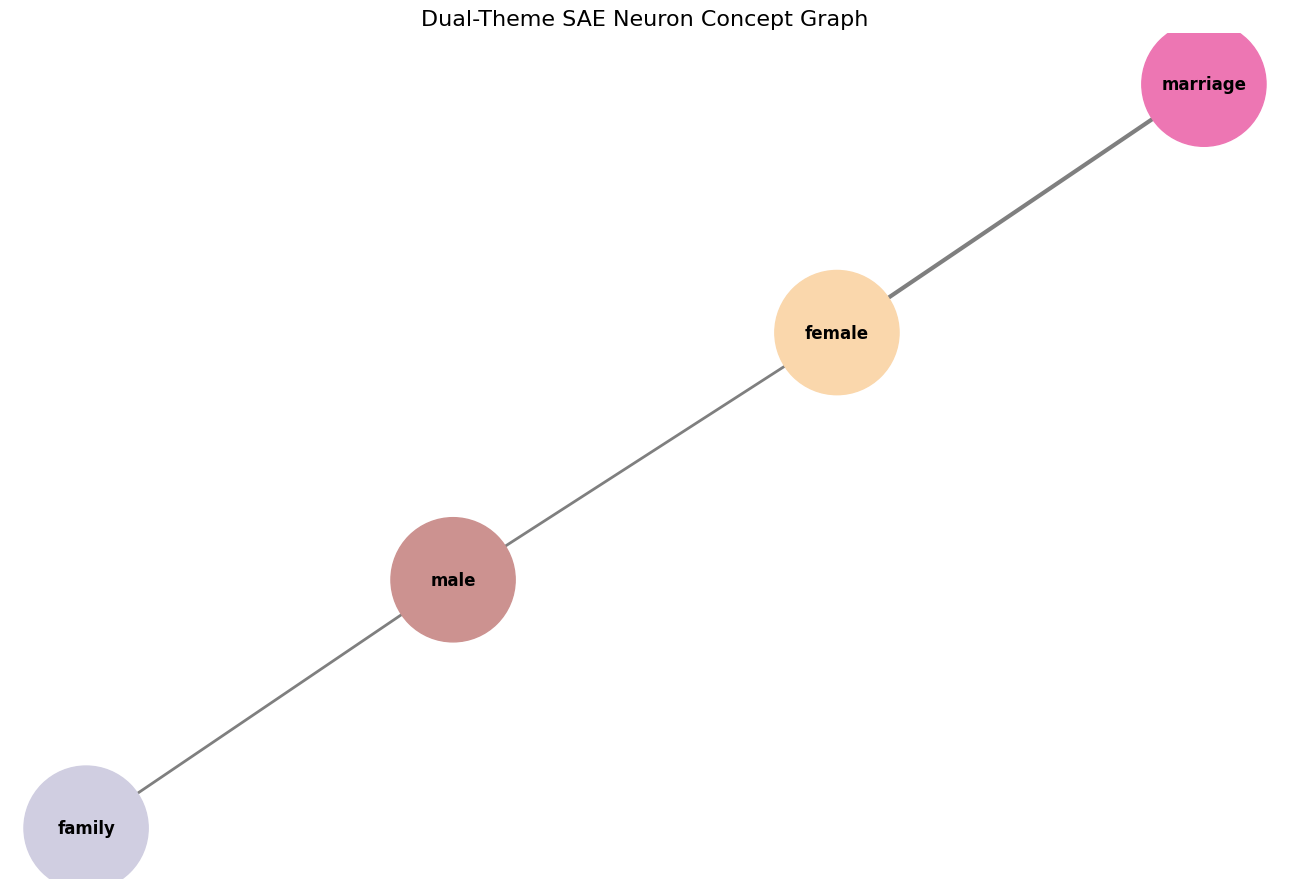

In [16]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l1.csv", layout="kk")

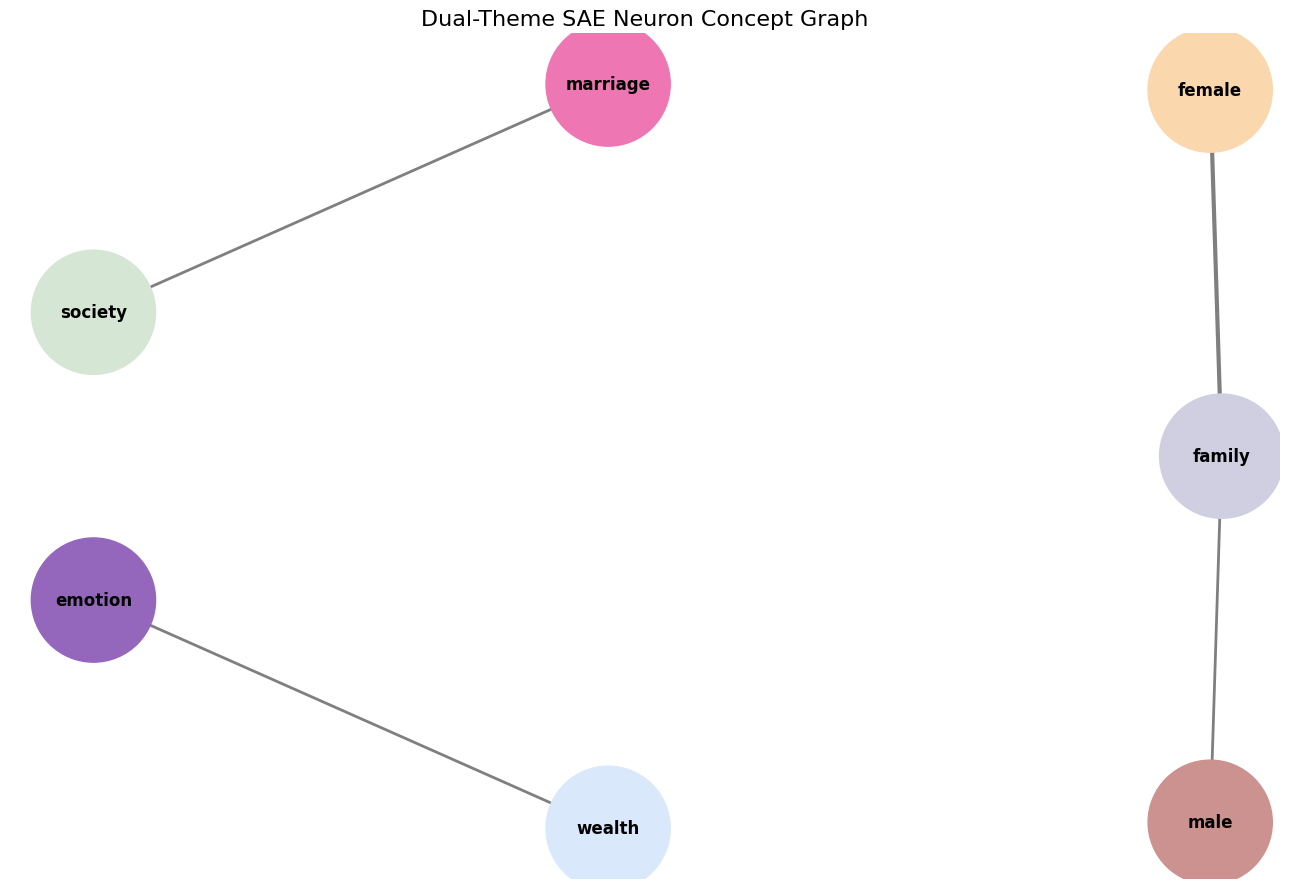

In [17]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l2.csv", layout="kk")

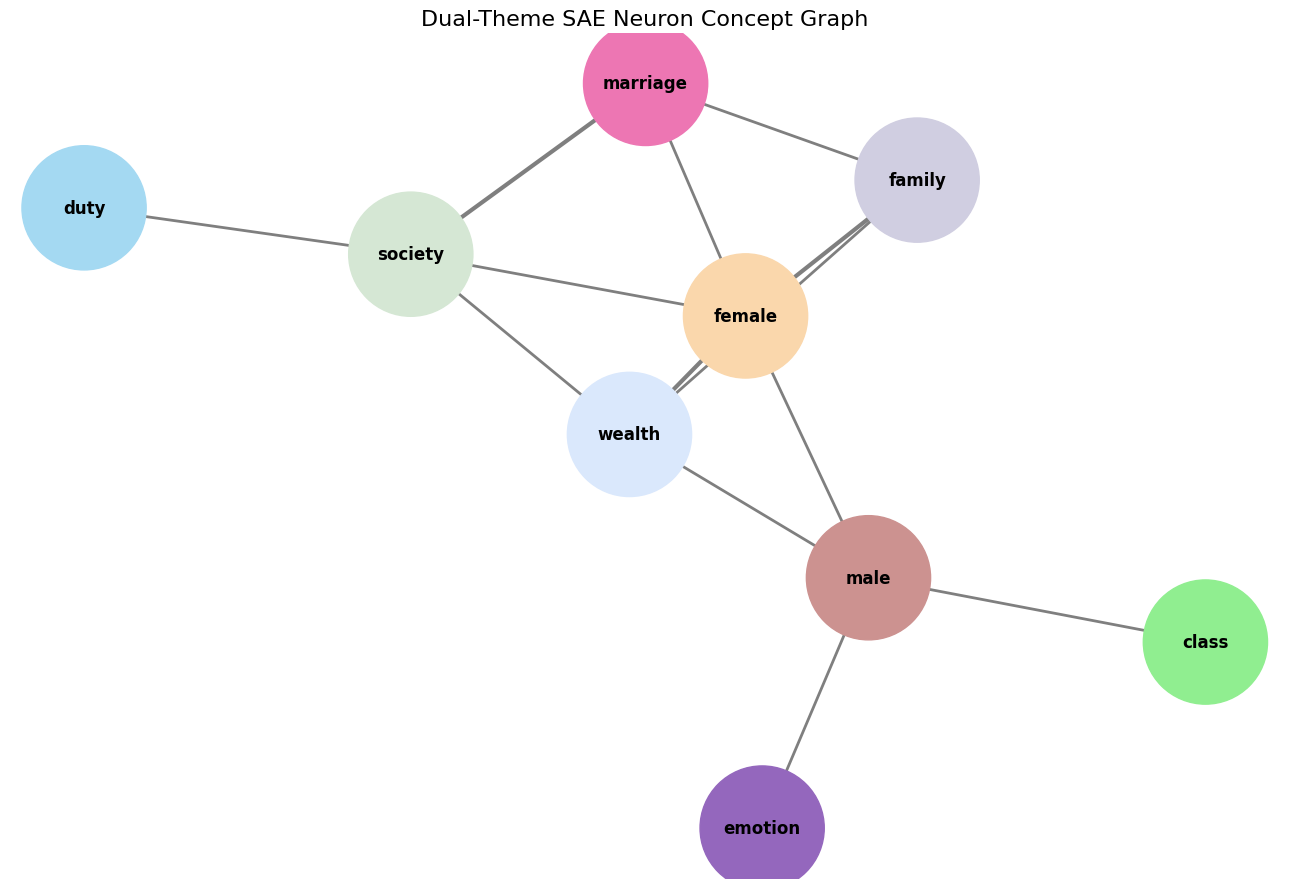

In [18]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l3.csv", layout="kk")

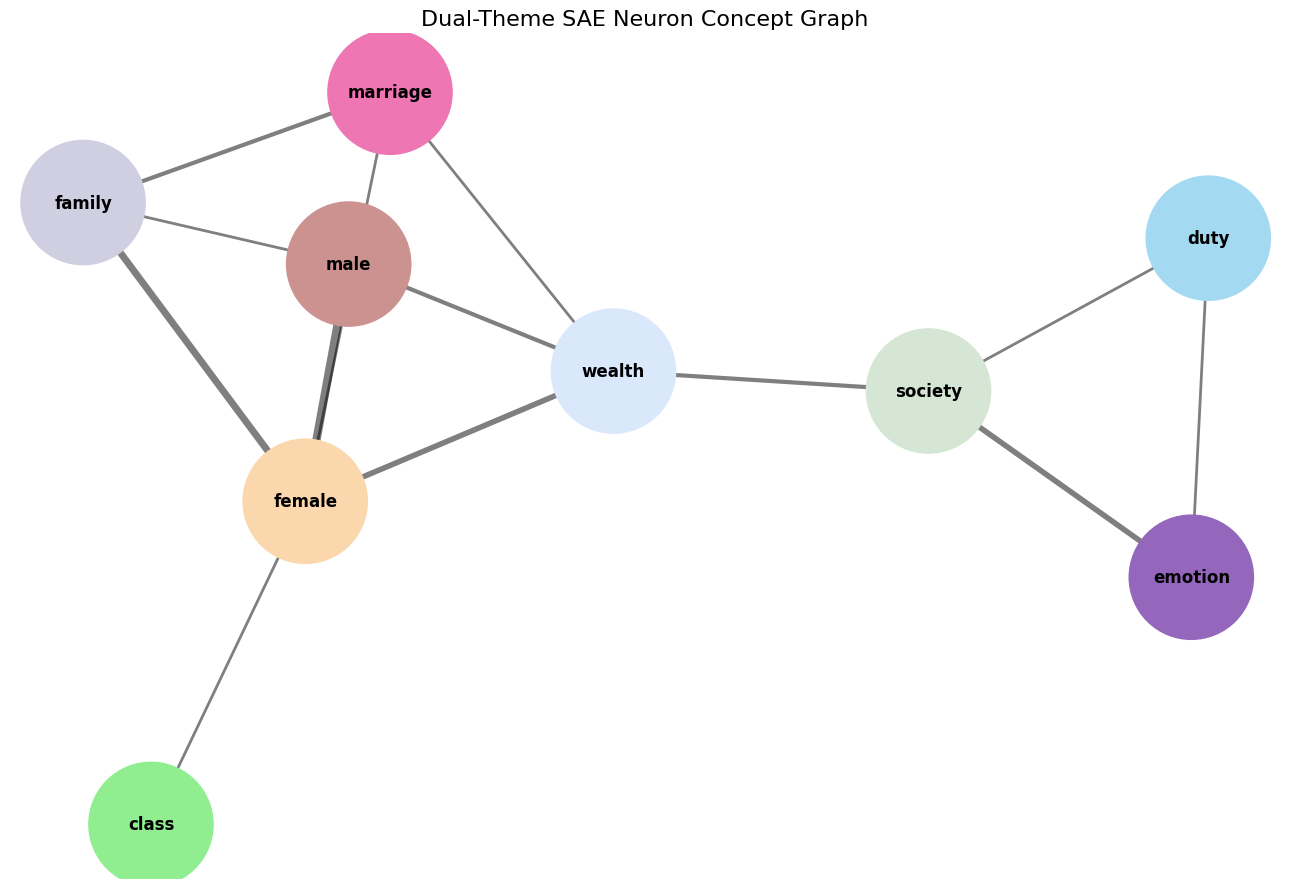

In [19]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l4.csv", layout="kk")

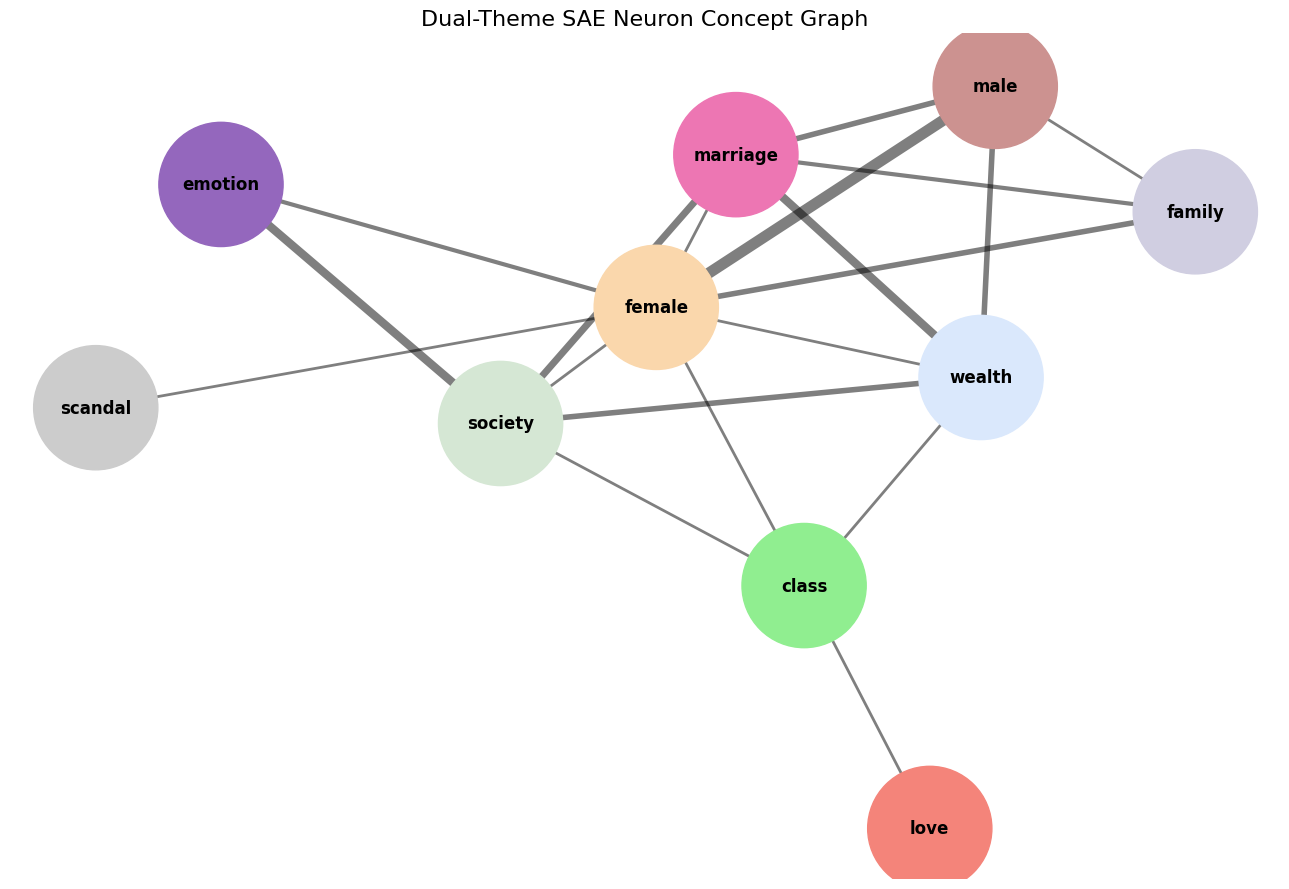

In [20]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l5.csv", layout="kk")

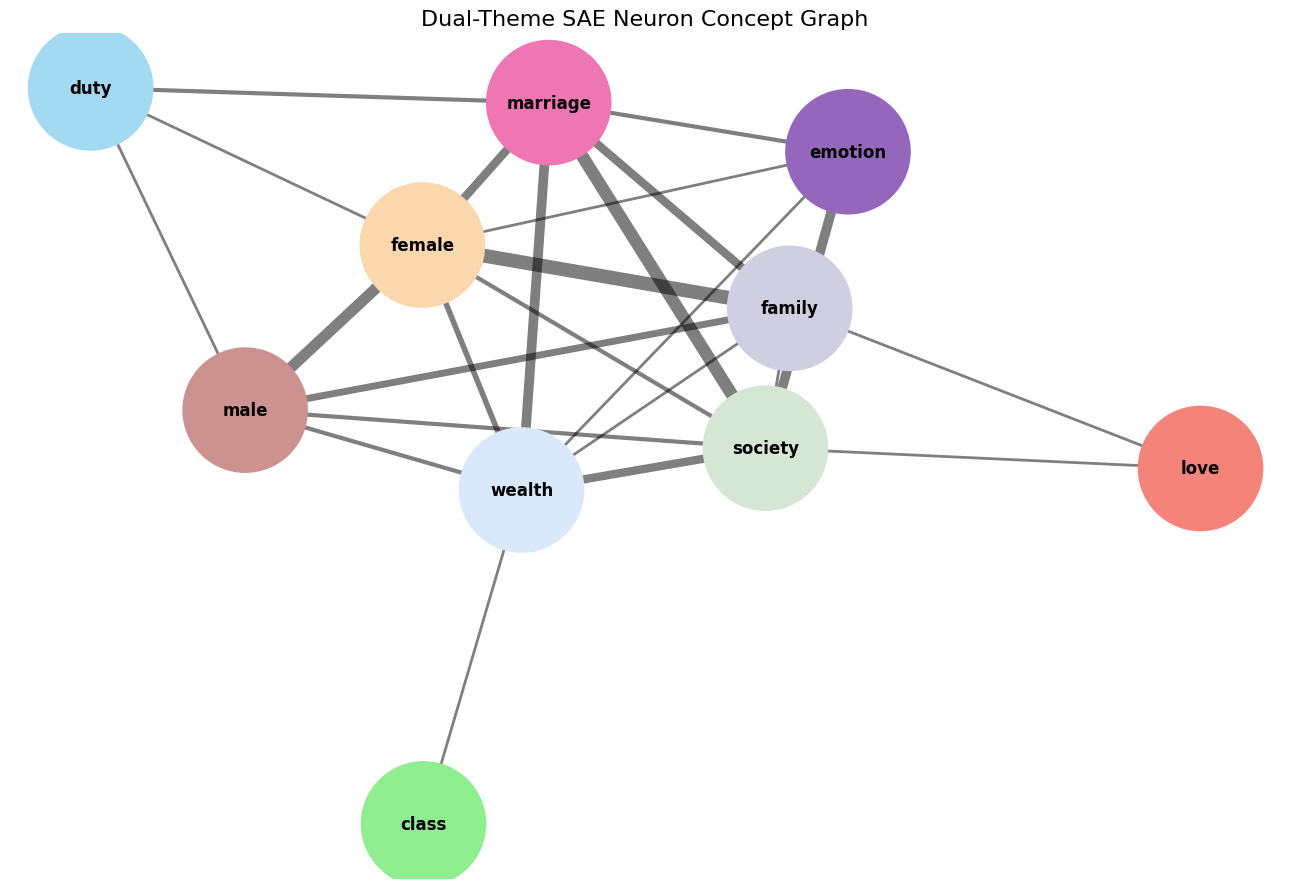

In [21]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l6.csv", layout="kk")

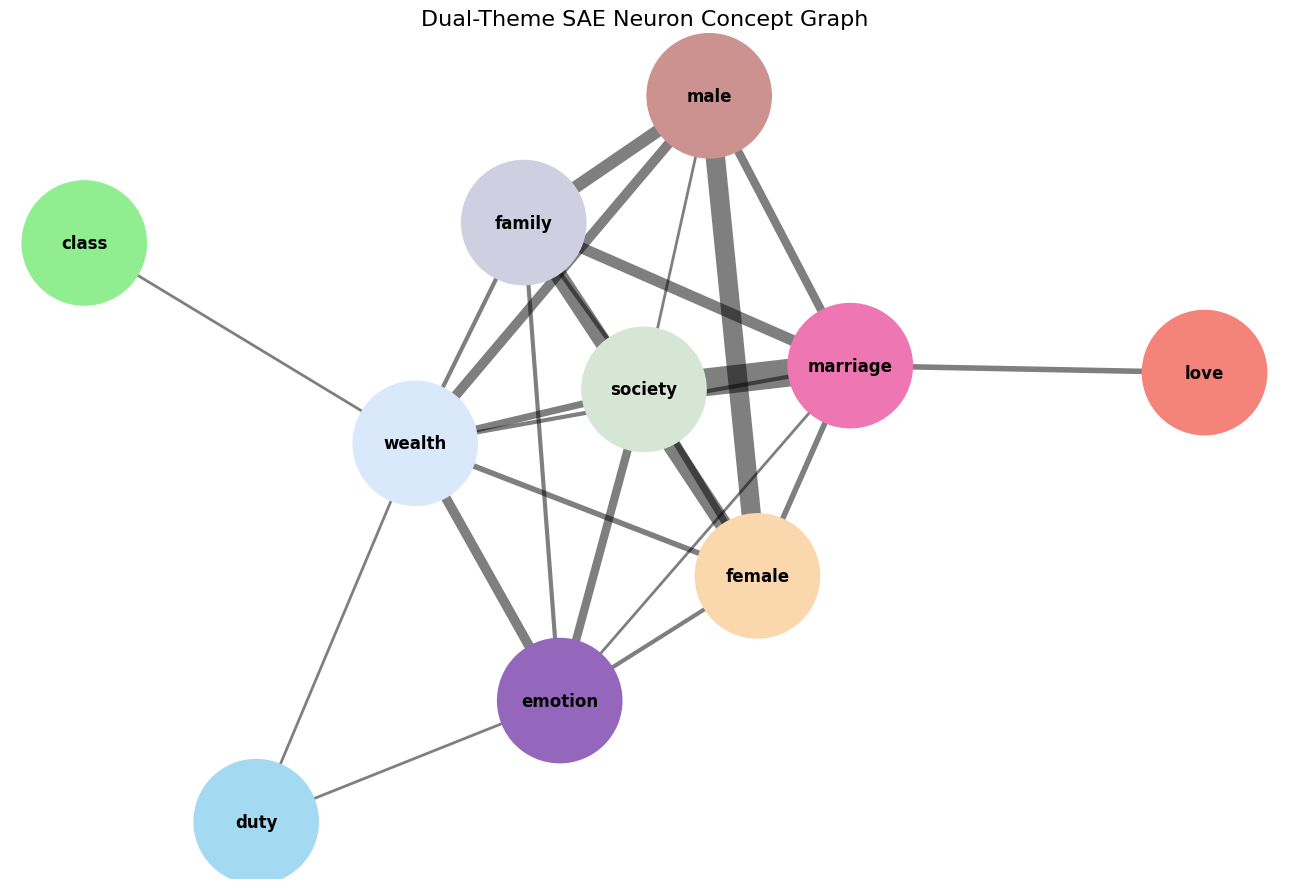

In [22]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l7.csv", layout="kk")

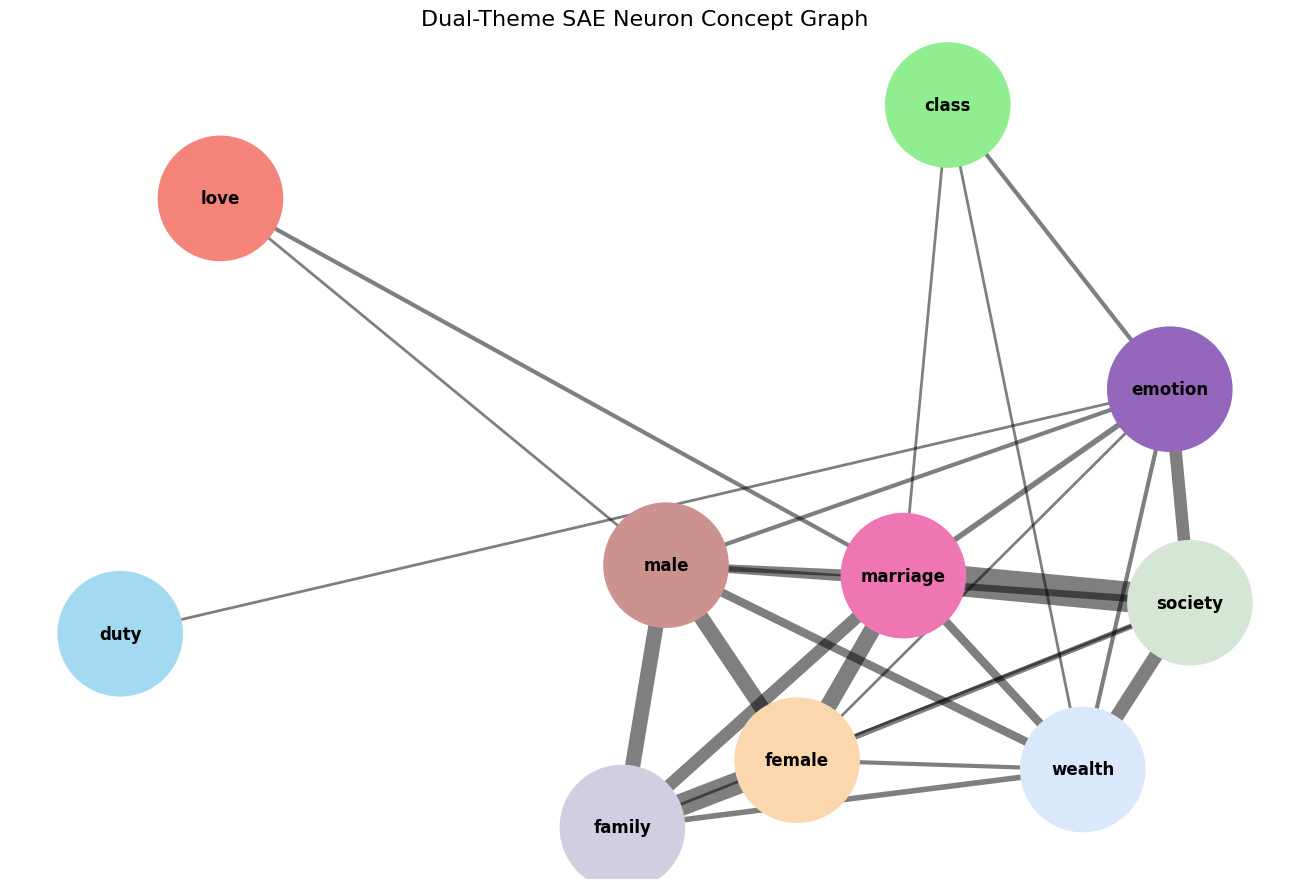

In [23]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l8.csv", spread=25.5)

In [24]:
import glob, os
import pandas as pd

base_dir = "sae_probing"
pattern = os.path.join(base_dir, "neuron_concept_primary_secondary_l*.csv")
files = sorted(glob.glob(pattern))

dfs = []
for f in files:
    df = pd.read_csv(f)
    # make sure each file has a 'layer' column
    if "layer" not in df.columns:
        # try to parse layer number from filename
        layer_num = int(os.path.basename(f).split("_l")[-1].split(".")[0])
        df["layer"] = layer_num
    dfs.append(df)

merged = pd.concat(dfs, ignore_index=True)
out_path = os.path.join(base_dir, "neuron_concept_primary_secondary_all_layers.csv")
merged.to_csv(out_path, index=False)

print(f"✅ Merged {len(files)} files into {out_path}, total rows: {len(merged)}")

✅ Merged 8 files into sae_probing\neuron_concept_primary_secondary_all_layers.csv, total rows: 428


---
---

In [25]:
latents_l1 = exract_latent_activations(model, sae_1, layer=1)
latents_l2 = exract_latent_activations(model, sae_2, layer=2)
latents_l3 = exract_latent_activations(model, sae_3, layer=3)
latents_l4 = exract_latent_activations(model, sae_4, layer=4)
latents_l5 = exract_latent_activations(model, sae_5, layer=5)
latents_l6 = exract_latent_activations(model, sae_6, layer=6)
latents_l7 = exract_latent_activations(model, sae_7, layer=7)
latents_l8 = exract_latent_activations(model, sae_8, layer=8)

✅ Saved sae_probing/latent_activations_l1.pt with latents shape torch.Size([665, 2688]) and 665 ids.
✅ Saved sae_probing/latent_activations_l2.pt with latents shape torch.Size([665, 2688]) and 665 ids.
✅ Saved sae_probing/latent_activations_l3.pt with latents shape torch.Size([665, 3584]) and 665 ids.
✅ Saved sae_probing/latent_activations_l4.pt with latents shape torch.Size([665, 3584]) and 665 ids.
✅ Saved sae_probing/latent_activations_l5.pt with latents shape torch.Size([665, 3584]) and 665 ids.
✅ Saved sae_probing/latent_activations_l6.pt with latents shape torch.Size([665, 4480]) and 665 ids.
✅ Saved sae_probing/latent_activations_l7.pt with latents shape torch.Size([665, 4480]) and 665 ids.
✅ Saved sae_probing/latent_activations_l8.pt with latents shape torch.Size([665, 4480]) and 665 ids.


In [26]:
def map_layer_neurons(layer, activation_threshold=5.0):
    find_selective_neurons(layer=layer, activation_threshold=activation_threshold)
    calculate_neuron_to_concept_assoc(layer=layer, threshold=activation_threshold);

    mappings = build_neuron_concept_map(layer=layer)
    print(f"✅ Done for layer {layer}")
    print('='*10)
    
    return mappings.head()

In [27]:
map_layer_neurons(layer=1)

Layer 1: N=665 tokensets, H=2688 neurons.
Window [5, 150], thresh=5.0. Selective found: 4
-> IDs saved to: sae_probing\selective_neuron_ids_l1.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l1.csv (44 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l1.csv
✅ Done for layer 1


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,1,236,female,0.273281,marriage,0.242121,0.114022,two-strong
1,1,907,male,0.279841,female,0.259798,0.071624,two-strong
2,1,1406,marriage,0.267718,female,0.214815,0.197607,two-strong
3,1,1829,family,0.248801,male,0.217916,0.124136,two-strong


In [28]:
map_layer_neurons(layer=2)

Layer 2: N=665 tokensets, H=2688 neurons.
Window [5, 150], thresh=5.0. Selective found: 9
-> IDs saved to: sae_probing\selective_neuron_ids_l2.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l2.csv (99 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l2.csv
✅ Done for layer 2


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,2,285,female,0.281838,marriage,0.249828,0.113574,two-strong
1,2,301,male,0.232620,None,NaN,1.000000,dominant
2,2,422,female,0.291562,marriage,0.233794,0.198133,two-strong
3,2,999,male,0.249850,family,0.224060,0.103221,two-strong
4,2,1240,male,0.269751,family,0.224400,0.168123,two-strong


In [29]:
map_layer_neurons(layer=3)

Layer 3: N=665 tokensets, H=3584 neurons.
Window [5, 150], thresh=5.0. Selective found: 20
-> IDs saved to: sae_probing\selective_neuron_ids_l3.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l3.csv (220 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l3.csv
✅ Done for layer 3


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,3,181,female,0.372378,male,0.312383,0.161111,two-strong
1,3,221,marriage,0.238576,family,0.211312,0.114280,two-strong
2,3,293,marriage,0.266885,emotion,0.191971,0.280696,leaning
3,3,344,male,0.269751,family,0.210195,0.220783,leaning
4,3,383,female,0.280485,None,NaN,1.000000,dominant


In [30]:
map_layer_neurons(layer=4)

Layer 4: N=665 tokensets, H=3584 neurons.
Window [5, 150], thresh=5.0. Selective found: 34
-> IDs saved to: sae_probing\selective_neuron_ids_l4.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l4.csv (374 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l4.csv
✅ Done for layer 4


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,4,10,female,0.337278,family,0.295963,0.122496,two-strong
1,4,52,emotion,0.313851,male,0.312464,0.004419,two-strong
2,4,76,marriage,0.393562,duty,0.217554,0.447217,leaning
3,4,117,male,0.213868,female,0.212472,0.006525,two-strong
4,4,208,family,0.382381,male,0.317750,0.169022,two-strong


In [31]:
map_layer_neurons(layer=5)

Layer 5: N=665 tokensets, H=3584 neurons.
Window [5, 150], thresh=5.0. Selective found: 62
-> IDs saved to: sae_probing\selective_neuron_ids_l5.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l5.csv (682 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l5.csv
✅ Done for layer 5


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,5,4,marriage,0.260440,scandal,0.126387,0.514717,dominant
1,5,44,society,0.266867,scandal,0.157077,0.411402,leaning
2,5,60,female,0.329501,family,0.313789,0.047683,two-strong
3,5,210,marriage,0.247768,society,0.230182,0.070975,two-strong
4,5,221,society,0.381826,wealth,0.195825,0.487137,leaning


In [32]:
map_layer_neurons(layer=6)

Layer 6: N=665 tokensets, H=4480 neurons.
Window [5, 150], thresh=5.0. Selective found: 105
-> IDs saved to: sae_probing\selective_neuron_ids_l6.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l6.csv (1155 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l6.csv
✅ Done for layer 6


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,6,2,love,0.325044,emotion,0.309545,0.047682,two-strong
1,6,101,marriage,0.236350,family,0.212175,0.102287,two-strong
2,6,226,male,0.251186,duty,0.147797,0.411601,leaning
3,6,263,society,0.287519,emotion,0.191411,0.334266,leaning
4,6,271,marriage,0.298230,None,NaN,1.000000,dominant


In [33]:
map_layer_neurons(layer=7)

Layer 7: N=665 tokensets, H=4480 neurons.
Window [5, 150], thresh=5.0. Selective found: 148
-> IDs saved to: sae_probing\selective_neuron_ids_l7.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l7.csv (1628 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l7.csv
✅ Done for layer 7


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,7,2,society,0.397126,emotion,0.203798,0.486819,leaning
1,7,19,female,0.330570,duty,0.148396,0.551089,dominant
2,7,98,marriage,0.308285,emotion,0.238506,0.226346,leaning
3,7,101,marriage,0.242748,family,0.218740,0.098900,two-strong
4,7,121,family,0.561747,female,0.297654,0.470128,leaning


In [34]:
map_layer_neurons(layer=8)

Layer 8: N=665 tokensets, H=4480 neurons.
Window [5, 150], thresh=5.0. Selective found: 142
-> IDs saved to: sae_probing\selective_neuron_ids_l8.pt
✅ Associations table saved: sae_probing\neuron_label_assoc_l8.csv (1562 rows)
✅ Primary/secondary mapping saved: sae_probing\neuron_concept_primary_secondary_l8.csv
✅ Done for layer 8


,layer,neuron,primary_concept,primary_AP,secondary_concept,secondary_AP,polarity_score,polarity_flag
0,8,5,family,0.246946,wealth,0.188201,0.237886,leaning
1,8,23,marriage,0.235905,scandal,0.180980,0.232827,leaning
2,8,82,class,0.164589,None,NaN,1.000000,dominant
3,8,128,male,0.319260,love,0.143391,0.550864,dominant
4,8,132,marriage,0.267254,family,0.190498,0.287202,leaning


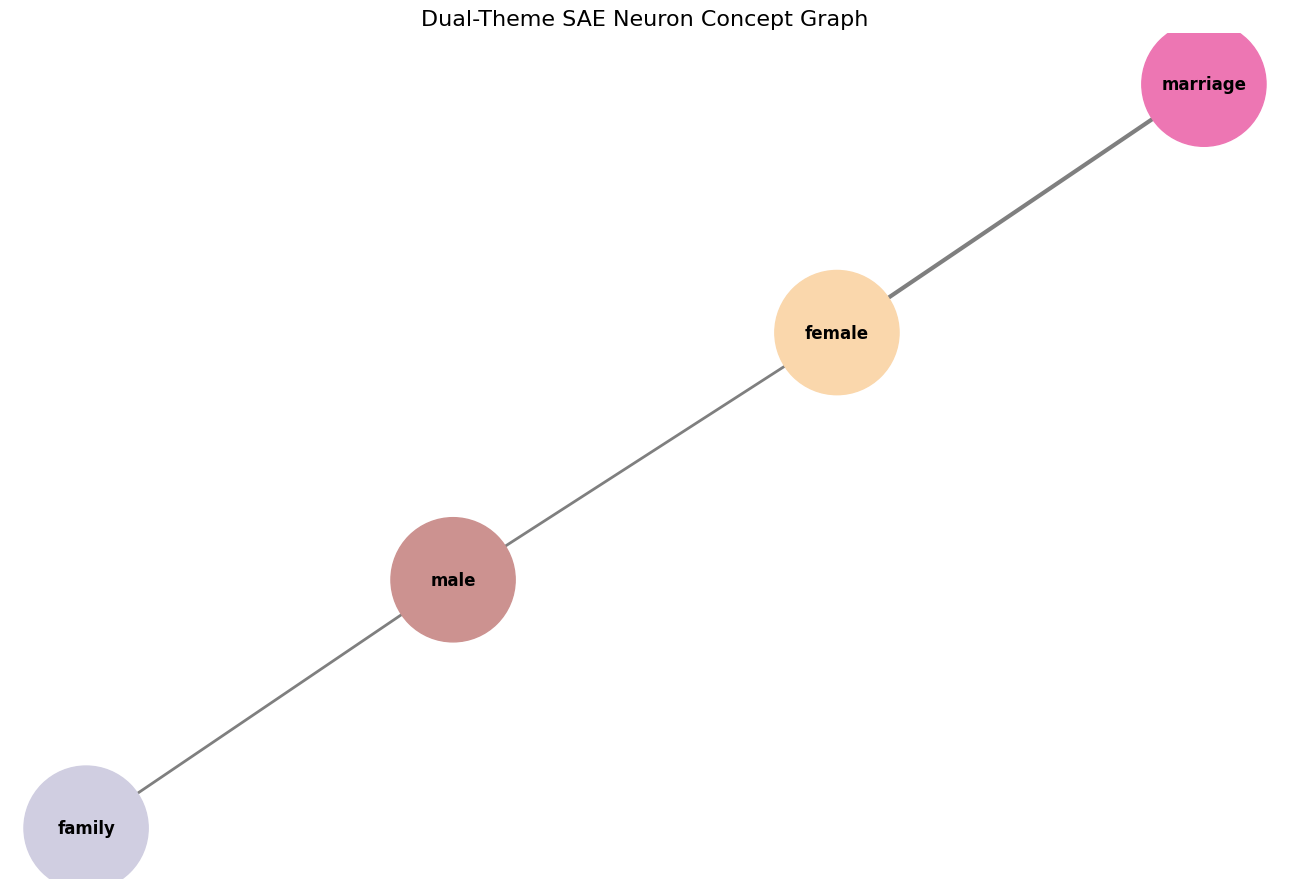

In [35]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l1.csv", layout="kk")

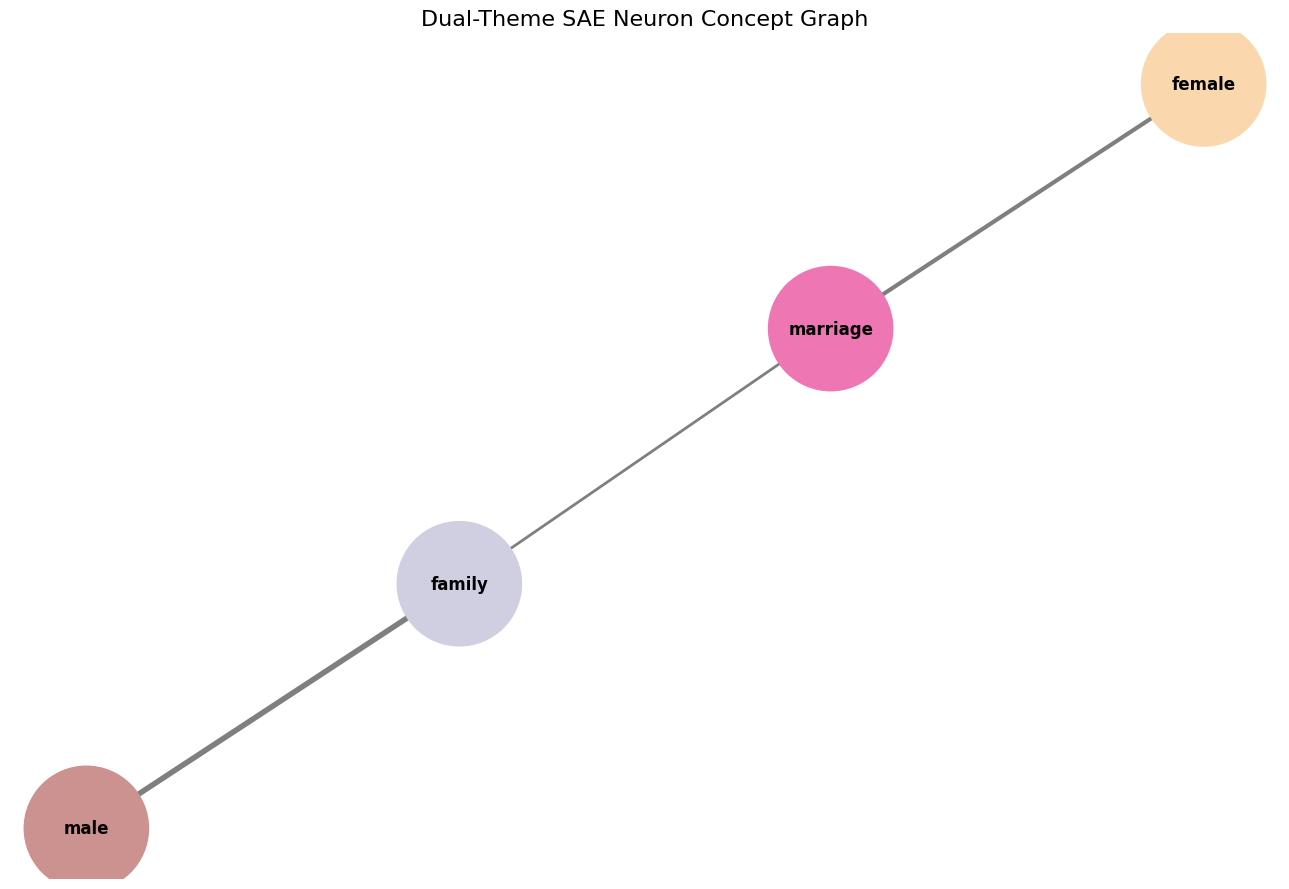

In [36]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l2.csv", layout="kk")

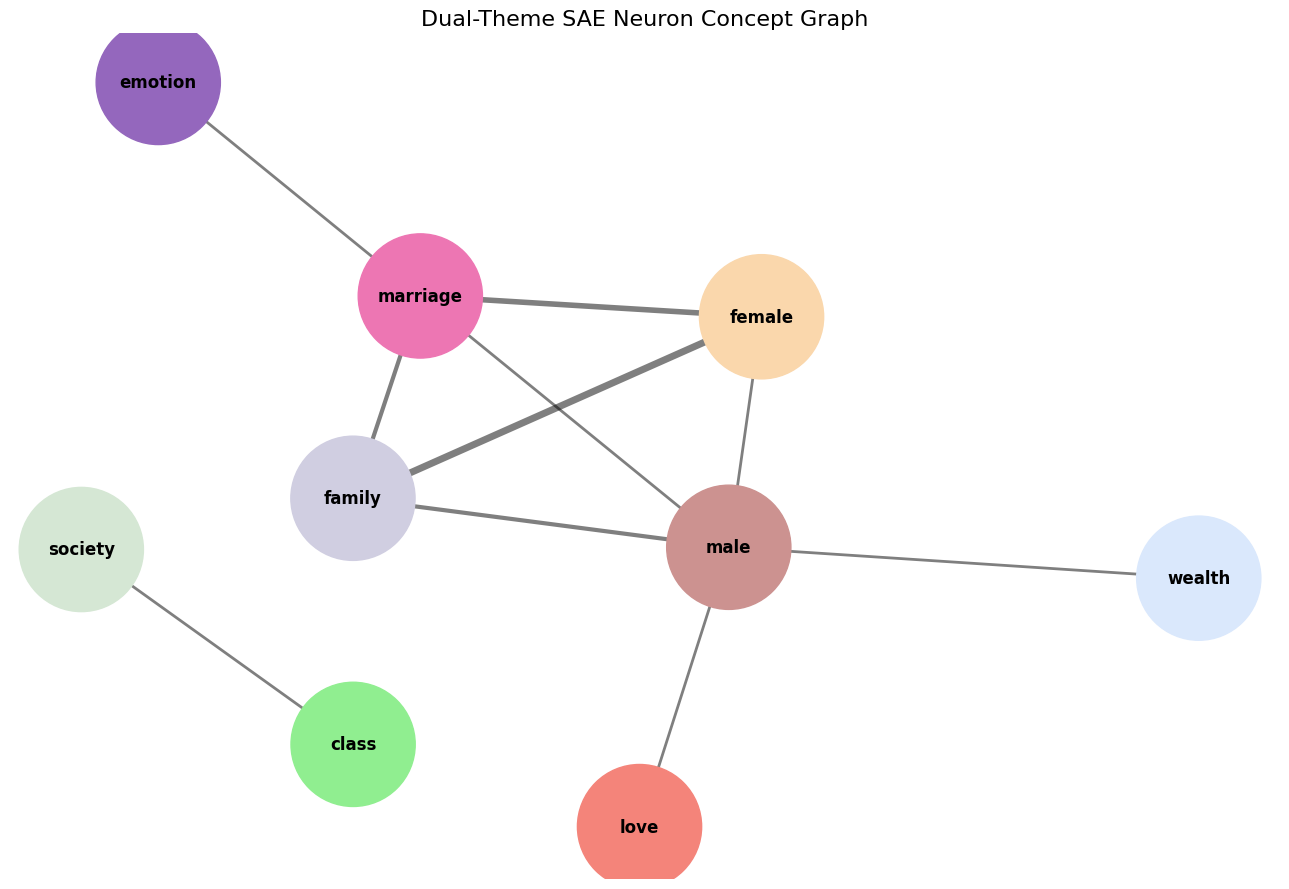

In [37]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l3.csv", layout="kk")

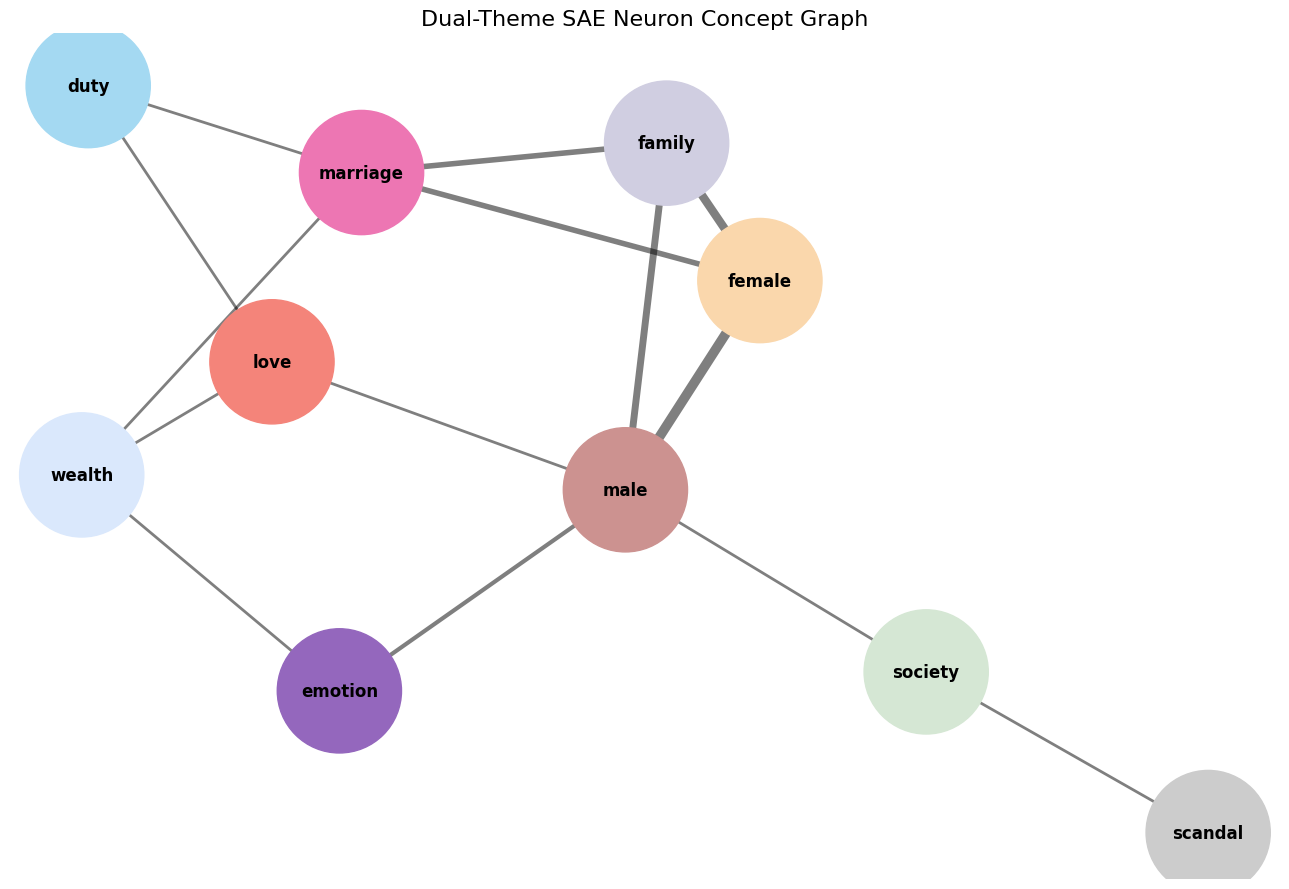

In [38]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l4.csv", layout="kk")

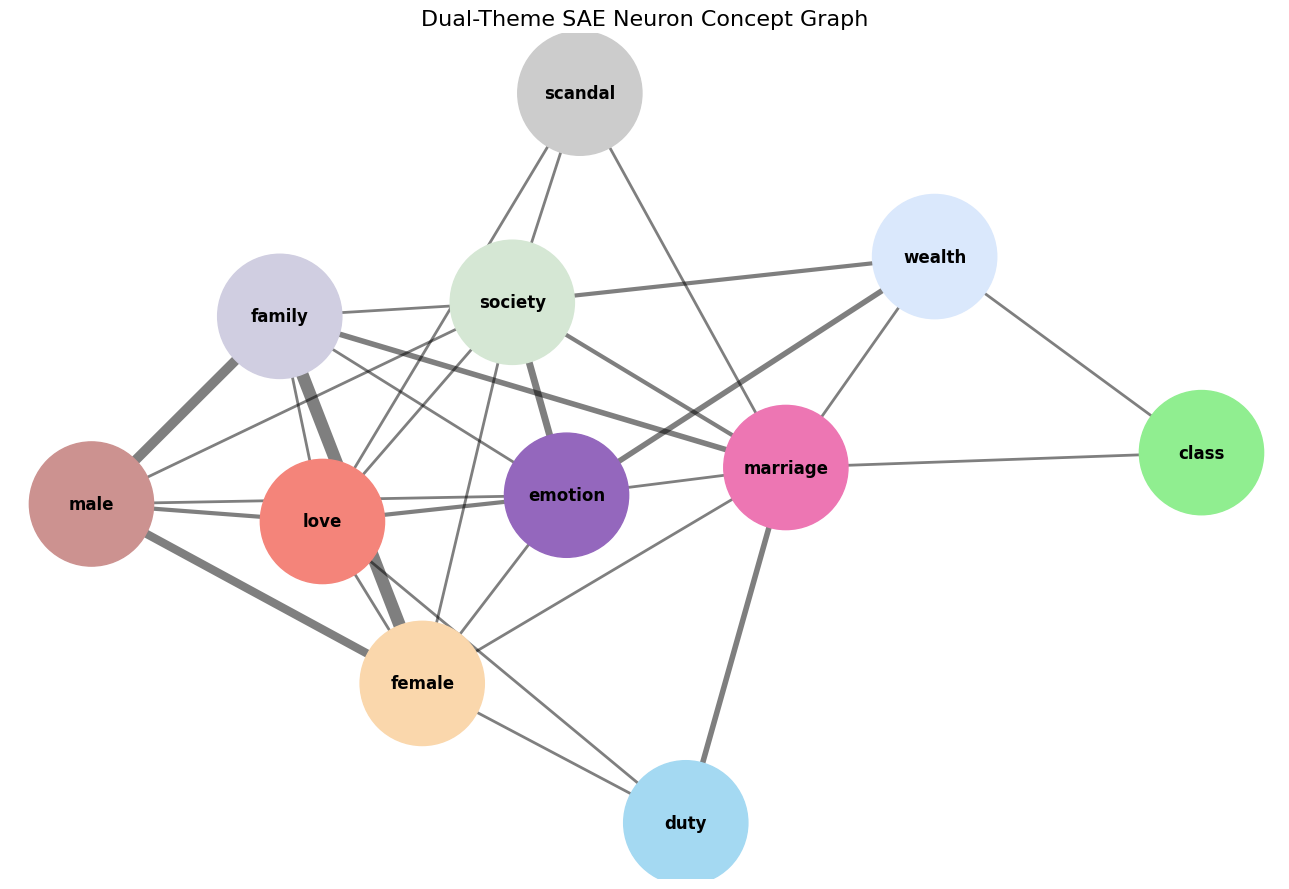

In [39]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l5.csv", layout="kk")

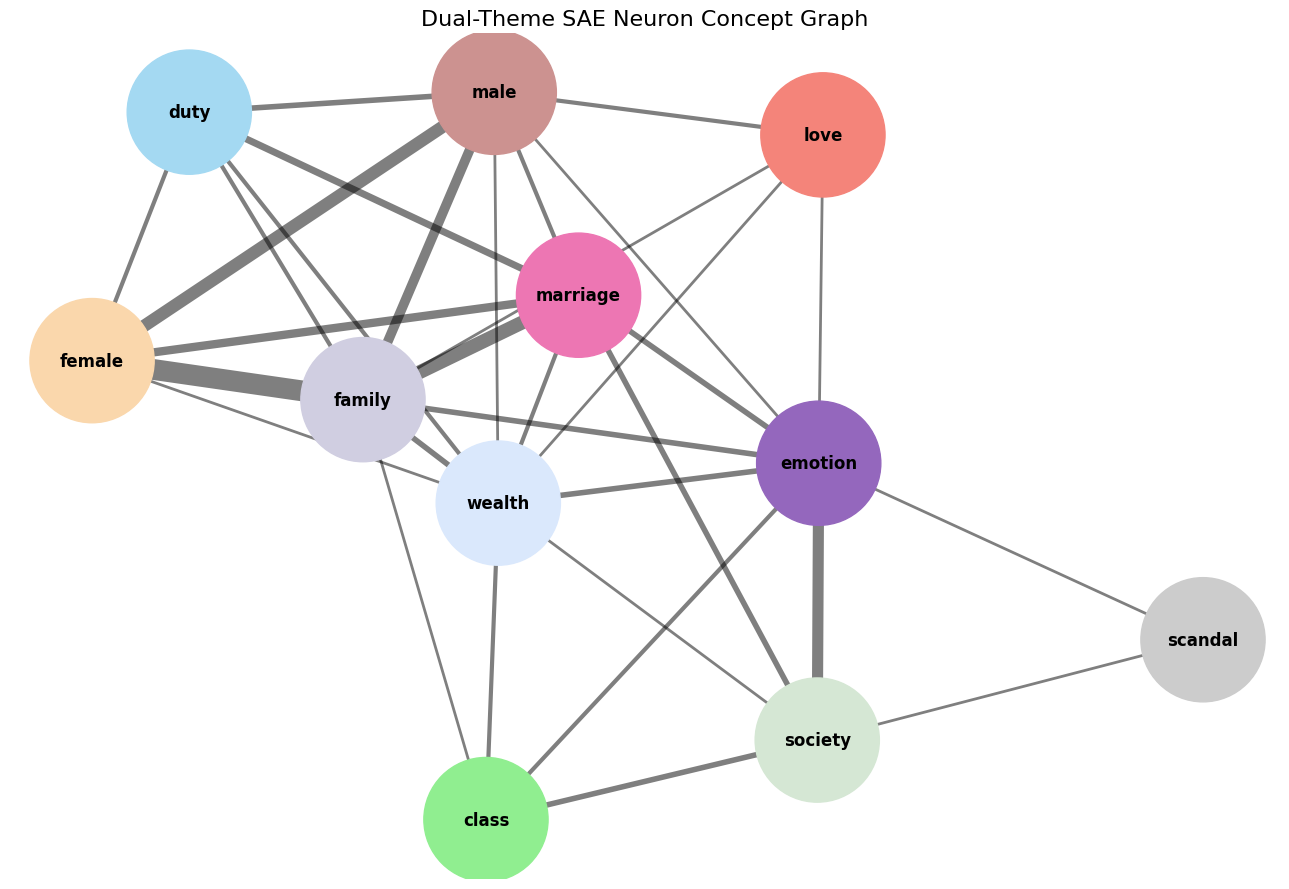

In [40]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l6.csv", layout="kk")

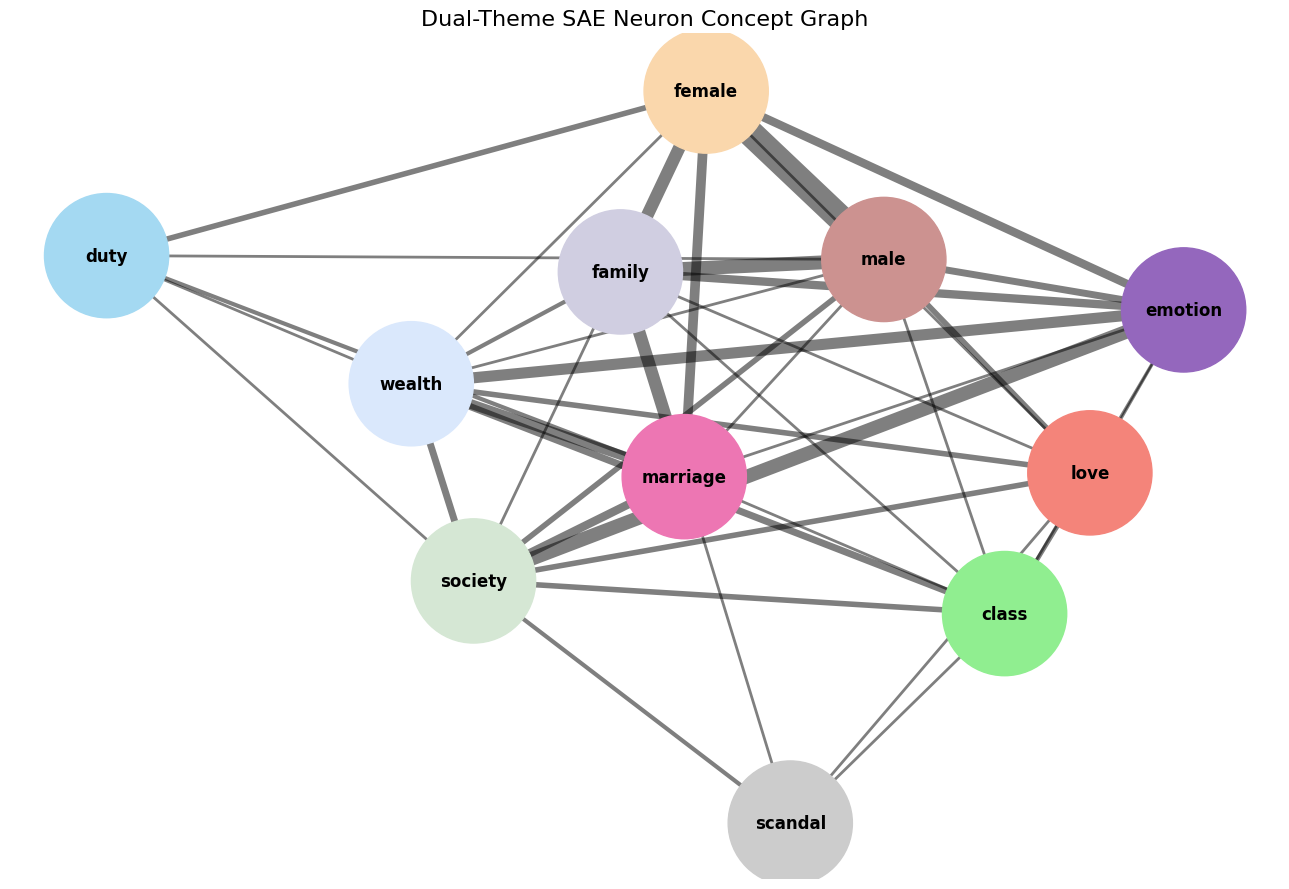

In [41]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l7.csv", layout="kk")

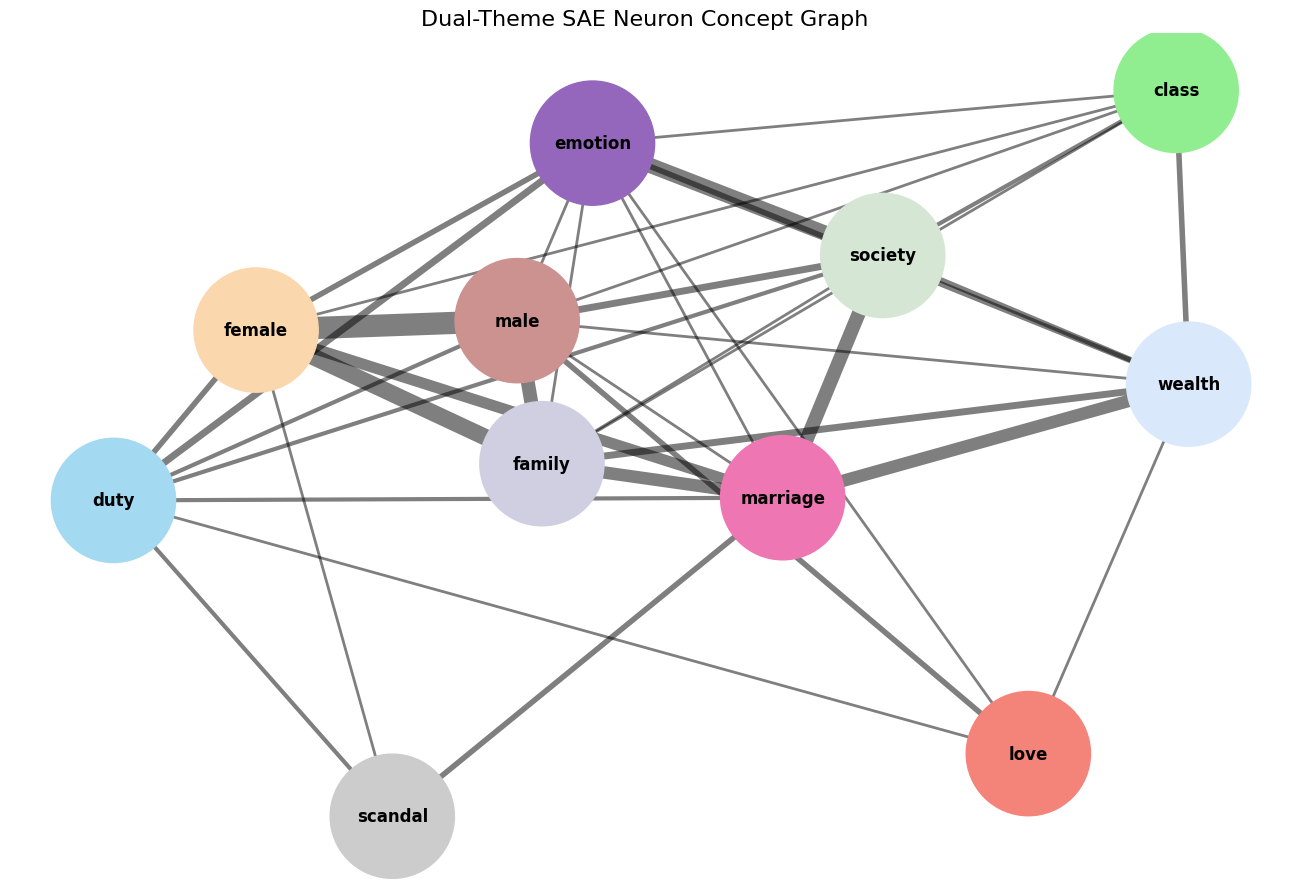

In [42]:
plot_dual_theme_graph_from_csv("sae_probing/neuron_concept_primary_secondary_l8.csv", spread=25.5)

In [43]:
import glob, os
import pandas as pd

base_dir = "sae_probing"
pattern = os.path.join(base_dir, "neuron_concept_primary_secondary_l*.csv")
files = sorted(glob.glob(pattern))

dfs = []
for f in files:
    df = pd.read_csv(f)
    # make sure each file has a 'layer' column
    if "layer" not in df.columns:
        # try to parse layer number from filename
        layer_num = int(os.path.basename(f).split("_l")[-1].split(".")[0])
        df["layer"] = layer_num
    dfs.append(df)

merged = pd.concat(dfs, ignore_index=True)
out_path = os.path.join(base_dir, "neuron_concept_primary_secondary_all_layers.csv")
merged.to_csv(out_path, index=False)

print(f"✅ Merged {len(files)} files into {out_path}, total rows: {len(merged)}")

✅ Merged 8 files into sae_probing\neuron_concept_primary_secondary_all_layers.csv, total rows: 523


In [4]:
!pip install pandoc 


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pypandoc
pypandoc.download_pandoc()

pypandoc.convert_text(
    open("C:\\Users\\IuG_Lap1\\Downloads\\53-11-en-elan.rtf").read(),
    'docx',
    format='rtf',
    outputfile='output.docx',
    extra_args=['--standalone']
)

''